>### Import libraries

In [56]:
import heapq
import numpy as np
from copy import deepcopy
import math
import pandas as pd
from collections import defaultdict
import random
import copy
import os
import matplotlib.pyplot as plt
from graphviz import Digraph
from collections import defaultdict, deque
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import tracemalloc



>### Data Processing



In [57]:

df=pd.read_csv('Crop_recommendationV2.csv')
X = df.drop(columns=['label'])  # all features
y = df['label']  # crop type

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importance)


humidity                  0.193329
rainfall                  0.189045
K                         0.158732
P                         0.130759
N                         0.099154
temperature               0.075847
ph                        0.063010
wind_speed                0.008348
pest_pressure             0.008098
urban_area_proximity      0.007506
co2_concentration         0.007418
organic_matter            0.007339
soil_moisture             0.007245
sunlight_exposure         0.007118
frost_risk                0.007003
water_usage_efficiency    0.006994
fertilizer_usage          0.006909
crop_density              0.006684
irrigation_frequency      0.003381
soil_type                 0.002140
water_source_type         0.002019
growth_stage              0.001923
dtype: float64


In [58]:

# Check for missing values
missing_values = df.isnull().sum()

print("\nTotal Missing Values:", missing_values.sum())


# Define columns to keep
keep_columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label', 'frost_risk', 'pest_pressure', 'crop_density']

# Define numerical columns to normalize
numerical_columns = ['frost_risk', 'pest_pressure', 'crop_density']

# Keep only the specified columns
df = df[keep_columns]

# Save original values for comparison
original_df = df[numerical_columns].copy()

# Apply Min-Max Normalization
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Save the normalized dataset
df.to_csv('Crop_Data.csv', index=False)

# Return the new dataset
df


Total Missing Values: 0


,N,P,K,temperature,humidity,ph,rainfall,label,frost_risk,pest_pressure,crop_density
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,0.956885,0.576005,0.449780
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,0.772862,0.747393,0.787017
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,0.181550,0.009969,0.510544
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,0.828447,0.240668,0.391082
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,0.254364,0.387944,0.590529
...,...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,0.777406,0.874405,0.907154
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,0.223037,0.369403,0.694978
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,0.417686,0.796838,0.530717
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,0.496133,0.309859,0.791757


In [59]:
def get_crop_requirements(file_path=None):
    """
    Generate sample crop requirements if data file isn't available or has errors
    """


    df = pd.read_csv(file_path)


    if 'label' in df.columns:

        features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
        crop_stats = df.groupby('label')[features].agg(['min', 'max'])
        df = df[features + ['label']].rename(columns={'label': 'Crop_Type'})
        profiles = {}
        for crop in df['Crop_Type'].unique():
            crop_data = df[df['Crop_Type'] == crop]
            profiles[crop] = {f: crop_data[f].mean() for f in features}
        crop_requirements = {}
        for crop in crop_stats.index:
            feature_ranges = {}
            for feature in features:
                        min_val = crop_stats.loc[crop, (feature, 'min')]
                        max_val = crop_stats.loc[crop, (feature, 'max')]
                        feature_ranges[feature] = (round(min_val, 1), round(max_val, 1))
            crop_requirements[crop] = feature_ranges

        return crop_requirements,df, features, profiles


>### Node class

In [60]:
class Node:
    def __init__(self, state=None, parent=None, action=None, cost=0, h=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
        self.h = h
        # Depth and children for visualization
        self.depth = 0 if parent is None else parent.depth + 1
        self.children = []

    # Comparison operators for priority queue ordering
    def __lt__(self, other): return (self.h + self.cost) < (other.h + other.cost)
    def __gt__(self, other): return (self.h + self.cost) > (other.h + other.cost)
    def __le__(self, other): return (self.h + self.cost) <= (other.h + other.cost)
    def __ge__(self, other): return (self.h + self.cost) >= (other.h + other.cost)
    def __eq__(self, other): return (self.h + self.cost) == (other.h + other.cost)
    def __ne__(self, other): return (self.h + self.cost) != (other.h + other.cost)

>### agricultural_practices_effects

In [61]:
# Define agricultural practices and their effects
agricultural_practices_effects = {
    "add_organic_matter": {
        "unit": "tonnes/ha",
        "effects": {
            "N": {
                "effect_per_unit": 0.055,  # % total N increase per tonne/ha of compost
                "notes": "4.5 t/ha compost increases total N by ~0.25 percentage points"
            },
            "P": {
                "effect_per_unit": 8.5,  # % increase in available P per tonne/ha of compost
                "notes": "4.5 t/ha compost increases available P by ~38.5%"
            },
            "K": {
                "effect_per_unit": 4.17,  # ppm K increase per % SOM increase
                "notes": "2.4% SOM increase raises soil K by ~100 ppm; 10 t/ha adds ~100-200 kg K₂O"
            },
            "humidity": {  # Changed from moisture to match feature naming in dataset
                "effect_per_unit": 3.8,  # % soil moisture increase per tonne/ha of compost
                "notes": "4.5 t/ha compost increases soil moisture by ~17%"
            },
            "ph": {  # Changed from pH to match feature naming in dataset
                "effect_per_unit": 0.017,  # pH unit increase per tonne/ha of compost (over 3 years)
                "notes": "15-45 t/ha compost over 3 years raises pH by 0.5-0.75 units"
            }
        }
    },

    "irrigation_frequency": {
        "unit": "days_between_irrigation",
        "effects": {
            "N": {
                "effect_per_unit": 0.017,  # % increase in available N per additional day between irrigation events
                "notes": "9-day vs 3-day interval showed ~10% higher soil N; 10% ÷ 6 days ≈ 1.7% per day"
            },
            "P": {
                "effect_per_unit": 0.007,  # % increase in available P per day (optimal around 7-day interval)
                "notes": "7-day interval optimal for P availability, showing ~4% higher P than 3-day"
            },
            "K": {
                "effect_per_unit": 0.026,  # % increase in available K per additional day between irrigation
                "notes": "9-day vs 3-day interval showed ~10_23% higher soil K; Average:16% ÷ 6 days ≈ 2.6% per day"
            },
            "humidity": {  # Changed from moisture to match feature naming
                "effect_per_unit": -0.03,  # fractional decrease in average moisture per additional day between irrigation
                "notes": "Less frequent irrigation reduces average soil moisture by ~3% per additional day"
            }
        }
    },

    "apply_N_fertilizer": {
        "unit": "kg N/ha",
        "effects": {
            "N": {
                "effect_per_unit": 0.375,  # ppm soil nitrate-N increase per kg N/ha applied
                "notes": "100 kg N/ha increases soil nitrate by ~25_50 ppm in top 30 cm (varies by soil)"
            }
        }
    },

    "apply_P_fertilizer": {
        "unit": "kg P₂O₅/ha",
        "effects": {
            "P": {
                "effect_per_unit": 0.2,  # ppm increase in soil-test P per kg P₂O₅/ha
                "notes": "50 kg P₂O₅/ha increases soil-test P by ~10 ppm (varies by soil fixation capacity)"
            }
        }
    },

    "apply_K_fertilizer": {
        "unit": "kg K₂O/ha",
        "effects": {
            "K": {
                "effect_per_unit": 0.4,  # ppm increase in soil-test K per kg K₂O/ha
                "notes": "100 kg K₂O/ha increases soil-test K by ~50 ppm (varies by soil CEC)"
            }
        }
    }
}



>### CropState class

In [62]:
class CropState:
    """
    Represents a state in the search space with environmental conditions and resource usage.
    """
    def __init__(self, environment, resource_usage=None, parent=None, action=None):
        # Environmental conditions (N, P, K, pH, temperature, humidity, etc.)
        self.environment = environment.copy()

        # Track resource usage (organic matter, irrigation, fertilizer)
        if resource_usage is None:
            self.resource_usage = {}
        else:
            self.resource_usage = resource_usage.copy()

        # Parent state and action taken to reach this state
        self.parent = parent
        self.action = action

    def __eq__(self, other):
        """Two states are equal if they have the same environmental conditions"""
        if not isinstance(other, CropState):
            return False
        return np.array_equal(self.environment, other.environment)

    def __hash__(self):
        """Hash function to use state in sets/dictionaries"""
        return hash(tuple(self.environment))




>### CropPredictionProblem

In [63]:
class CropPredictionProblem:
    """
    Defines the crop prediction problem
    """
    def __init__(self, initial_state, data_file='Crop_Data.csv'):
        """
        Initialize the problem with initial state and crop growth zones.

        Parameters:
        -----------
        initial_state : CropState
            The initial environmental conditions
        crop_requirements : dict
            Mapping of crop names to their optimal environmental conditions ranges
        """
        self.initial_state = initial_state
        self.crop_requirements,self.dataset, self.features, self.crop_profiles =get_crop_requirements(data_file)
        self.interventions = [
            ('add_organic_matter', (0, 15)),  # tonnes/ha
            ('irrigation_frequency', (1, 6)),  # days
            ('apply_N_fertilizer', (0, 200)),  # kg/ha
            ('apply_P_fertilizer', (0, 75)),
            ('apply_K_fertilizer', (0, 150))
        ]

        self.costs={
            'add_organic_matter': 60.0,    # $ per tonne
            'apply_N_fertilizer': 1.3,     # $ per kg N (urea)
            'apply_P_fertilizer': 1.7,     # $ per kg P2O5 (DAP)
            'apply_K_fertilizer': 0.7,     # $ per kg K2O (potash)
            'irrigation_frequency': 10.0,  # $ per day between irrigations
            'no_action': 0.0              # No cost for no action
        }

        # Define feature names and their indices in the state vector
        self.feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
        self.feature_indices = {feature: i for i, feature in enumerate(self.feature_names)}
    # Define feature weights to be used in the heuristic function
        self.feature_weights = {
            'rainfall': 0.188200,     # Highest weight
            'humidity': 0.182404,
            'K': 0.152758,
            'P': 0.139553,
            'N': 0.098114,
            'temperature': 0.079987,
            'ph': 0.059807            # Lowest weight
        }
    @staticmethod
    def choose_best_crop_from_labels(candidate_labels,
                                     weight_frost=1.0,
                                     weight_pest=1.0,
                                     weight_density=1.0,
                                     csv_path="Crop_Data.csv"):
        """
        From the normalized CSV, pick the label of the crop (string)
        among `candidate_labels` that minimizes:
            score = wf*frost_risk + wp*pest_pressure - wd*crop_density
        """
        df_norm = pd.read_csv(csv_path)
        best_score = float('inf')
        best_row = None

        for _, row in df_norm.iterrows():
            if row['label'] in candidate_labels:
                score = (
                    weight_frost   * row['frost_risk'] +
                    weight_pest    * row['pest_pressure'] -
                    weight_density * row['crop_density']
                )
                if score < best_score:
                    best_score = score
                    best_row = row

        if best_row is None:
            raise ValueError(f"No rows found for labels: {candidate_labels}")

        return best_row['label']  # ✅ Return just the label (string)

    def is_goal(self, current_state):
        """
        Check if the current state is a goal state (suitable for any crop).
        """
        candidates = []
        best_crop = None
        best_match_count = -1

        for crop_name, crop_ranges in self.crop_requirements.items():
            is_suitable, match_count = self._is_suitable_for_crop(current_state.environment, crop_name)

            if is_suitable:
                candidates.append(crop_name)
            elif match_count > best_match_count:
                best_match_count = match_count
                best_crop = crop_name

        if candidates:
            best_crop_label = self.choose_best_crop_from_labels(
                candidates,
                weight_frost=1.0,
                weight_pest=1.0,
                weight_density=1.0,
                csv_path="Crop_Data.csv"
            )
            return True, best_crop_label

        return False, best_crop

    def _is_suitable_for_crop(self, environment, crop_name):
        """
        Check if the environment is suitable for a specific crop.
        Returns: (is_suitable, match_count) tuple
        """
        crop_ranges = self.crop_requirements[crop_name]
        match_count = 0
        total_features = 0

        # Check each relevant environmental factor
        for feature, (min_val, max_val) in crop_ranges.items():
            idx = self.feature_indices.get(feature)
            if idx is not None and idx < len(environment):
                total_features += 1
                if min_val <= environment[idx] <= max_val:
                    match_count += 1
                else:
                    # Not in optimal range
                    pass

        # All features must match for suitability
        return match_count == total_features, match_count



    def get_valid_actions(self, state):
        """
        Dynamically generate valid actions based on available practices from the effects data.
        """
        valid_actions = []


        standard_amounts = {
           'add_organic_matter': [0, 5, 10],                 # tonnes/ha
            'apply_N_fertilizer': [0, 50, 100, 150],   # kg N/ha
            'apply_P_fertilizer': [0, 25, 50, 75],          # kg P₂O₅/ha
            'apply_K_fertilizer': [0, 50, 100, 150],        # kg K₂O/ha
            'irrigation_frequency': [1,2,3,4,5,6],          # days between irrigation
        }

        for action_type in agricultural_practices_effects.keys():
            if action_type in standard_amounts:
                for amt in standard_amounts[action_type]:
                    valid_actions.append((action_type, amt))

        # Optional: add "no action" for control scenarios
        valid_actions.append(('no_action', 0))

        return valid_actions

    def apply_action(self, state, action):
        """
        Apply an action to a state and return the new state using realistic effects data.
        """
        action_type, amount = action
        new_environment = state.environment.copy()
        new_resource_usage = state.resource_usage.copy() if state.resource_usage else {}

        if action_type in agricultural_practices_effects:
            effects = agricultural_practices_effects[action_type]["effects"]

            for feature, effect_info in effects.items():
                effect_per_unit = effect_info["effect_per_unit"]

                # Get the index of the feature from the state's feature mapping
                if feature in self.feature_indices:
                    idx = self.feature_indices[feature]
                    new_environment[idx] += amount * effect_per_unit

            # Track the applied resource
            if action_type not in new_resource_usage:
                new_resource_usage[action_type] = 0
            new_resource_usage[action_type] += amount

        # Create and return new state
        return CropState(new_environment, new_resource_usage)

    def get_action_cost(self, action):
        """
        Compute the cost (USD) of applying a given action at the specified amount.
        Unit costs and environmental factors are applied.
        """
        action_type, amount = action

        # Base costs (USD per unit action)
        base_rates = {
            'add_organic_matter': 60.0,    # $ per tonne
            'apply_N_fertilizer': 1.3,     # $ per kg N (urea)
            'apply_P_fertilizer': 1.7,     # $ per kg P2O5 (DAP)
            'apply_K_fertilizer': 0.7,     # $ per kg K2O (potash)
            'irrigation_frequency': 10.0,  # $ per day between irrigations
            'no_action': 0.0              # No cost for no action
        }



        # Use log(1 + amount) for diminishing returns
        if amount <= 0:
            return 0.0
        base_cost = base_rates.get(action_type, 0.0)
        cost = base_cost * np.log1p(amount)
        return float(cost)

    def heuristic(self, state):
        """
        Weighted heuristic function estimating cost to goal.

        Calculates how close the current environment is to any crop's optimal conditions
        using weighted cosine similarity. Returns a value that represents distance to goal,
        where lower values indicate states closer to being suitable for some crop.

        Feature weights prioritize: rainfall (0.188200), humidity (0.182404), K (0.152758),
        P (0.139553), N (0.098114), temperature (0.079987), and pH (0.059807).

        Returns:
            float: A value where lower values indicate better alignment with a crop's requirements
        """
        # Get the current environment vector
        current_environment = state.environment

        # Track the best (highest) similarity found so far
        best_similarity = -1.0  # Cosine similarity ranges from -1 to 1

        for crop_name, crop_ranges in self.crop_requirements.items():
            # Build vectors for comparison - using only features that exist in our feature_indices
            current_vector = []
            target_vector = []
            weight_vector = []

            for feature, (min_val, max_val) in crop_ranges.items():
                if feature in self.feature_indices:
                    idx = self.feature_indices[feature]

                    # Make sure the index is valid for our environment vector
                    if idx < len(current_environment):
                        current_value = current_environment[idx]
                        # Use midpoint of range as target value
                        target_value = (min_val + max_val) / 2
                        # Get the weight for this feature
                        weight = self.feature_weights.get(feature, 1.0)

                        current_vector.append(current_value)
                        target_vector.append(target_value)
                        weight_vector.append(weight)

          
            current_vector = np.array(current_vector)
            target_vector = np.array(target_vector)
            weight_vector = np.array(weight_vector)

            # Calculate weighted cosine similarity if vectors aren't empty
            if len(current_vector) > 0 and len(target_vector) > 0:
                # Apply weights to the current and target vectors
                weighted_current = current_vector * weight_vector
                weighted_target = target_vector * weight_vector

                # Compute magnitudes of weighted vectors
                norm_current = np.linalg.norm(weighted_current)
                norm_target = np.linalg.norm(weighted_target)

                # Compute similarity (avoid division by zero)
                if norm_current > 0 and norm_target > 0:
                    dot_product = np.dot(weighted_current, weighted_target)
                    similarity = dot_product / (norm_current * norm_target)
                    best_similarity = max(best_similarity, similarity)

        # Convert similarity to a distance metric (lower is better for A* search)
        # Cosine similarity ranges from -1 to 1, so this gives us a range of 0-2
        # where 0 is perfect alignment and 2 is perfect opposition
        return 1 - best_similarity


    def get_total_cost(self, g, state, use_cost, use_heuristic):
        """
        Calculate f(n) = g(n) + h(n) for a node.
        """

        total_cost = g if use_cost else 0
        if use_heuristic:
                total_cost += self.heuristic(state)
        return total_cost

    # functions for Genetic Algorithm

    def apply_interventions(self, chromosome):
        """Apply interventions to user conditions."""
        state_arr = copy.deepcopy(self.initial_state.environment)
        # convert the state from np array to dictionarry 
        state = {self.features[i]: state_arr[i] for i in range(len(self.features))}
        for i, (action, _) in enumerate(self.interventions):
            param = chromosome[i]
            effects = agricultural_practices_effects[action]["effects"]
            for feature, effect in effects.items():
                if feature in ['N', 'P', 'humidity']:  # Percentage increase
                    state[feature] *= (1 + param * effect["effect_per_unit"] / 100)
                else:  # Absolute increase (K, ph)
                    state[feature] += param * effect["effect_per_unit"]
        # Cap values
        for f in self.features:
            min_val, max_val = self.dataset[f].min(), self.dataset[f].max()
            state[f] = max(min_val, min(max_val, state[f]))
        return state

    def find_closest_crop(self, state):
        """Find crop with smallest Euclidean distance to state."""
        min_distance = float('inf')
        closest_crop = None
        for crop, means in self.crop_profiles.items():
            distance = math.sqrt(sum((state[f] - means[f]) ** 2 for f in self.features))
            if distance < min_distance:
                min_distance = distance
                closest_crop = crop
        return closest_crop, min_distance

    def evaluate(self, chromosome):  #fitness function
        """Compute fitness: distance to closest crop + cost."""
        # Apply interventions
        state = self.apply_interventions(chromosome)
        # Find closest crop
        closest_crop, distance = self.find_closest_crop(state)
        # Normalize distance
        max_distance = math.sqrt(sum((self.dataset[f].max() - self.dataset[f].min()) ** 2 for f in self.features))
        distance_score = 1 - (distance / max_distance)
        # Cost
        total_cost = sum(chromosome[i] * self.costs[action] for i, (action, _) in enumerate(self.interventions))
        max_cost = 500  # Estimated max
        cost_score = 1 - (total_cost / max_cost) if total_cost <= max_cost else 0
        # Fitness
        fitness = 0.7 * distance_score + 0.3 * cost_score
        return fitness, closest_crop

    def compute_all_suitability(self, chromosome):
        """Compute suitability scores for all crops."""
        state = self.apply_interventions(chromosome)
        max_distance = math.sqrt(sum((self.dataset[f].max() - self.dataset[f].min()) ** 2 for f in self.features))
        suitability_scores = {}
        for crop, means in self.crop_profiles.items():
            distance = math.sqrt(sum((state[f] - means[f]) ** 2 for f in self.features))
            suitability = (1 - (distance / max_distance)) * 100  # Convert to percentage
            suitability_scores[crop] = suitability
        return suitability_scores




> ### Other functions

In [64]:
def total_resource_usage(goal_node):
    """
    Traverse from the goal node back to the start and sum resource usage.

    Args:
        goal_node: The goal Node of the search, containing state and parent links.

    Returns:
        A dict where each key is a resource or action name and each value is the total amount used.
        For example: {'apply_N_fertilizer': 100, 'increase_irrigation': 30}
    """
    usage_totals = {}
    node = goal_node

    # Traverse back to the root node, aggregating resource usage
    while node is not None:
        state = getattr(node, 'state', None)
        # If this state tracks resource usage, add it
        if state and hasattr(state, 'resource_usage'):
            for key, amount in state.resource_usage.items():
                usage_totals[key] = usage_totals.get(key, 0) + amount
        node = node.parent

    return usage_totals


def reconstruct_path(goal_node):
    """
    Reconstructs the path from start to goal by following parent pointers.

    Args:
        goal_node: The goal node after search.

    Returns:
        List of (action, state) pairs representing the path.
    """
    path = []
    current = goal_node

    while current.parent is not None:
        # Add (action, state) to the beginning of the path
        path.append((current.action, current.state))
        current = current.parent

    # Reverse the path to get from start to goal
    path.reverse()
    return path


def print_path(path, goal_crop):
    """
    Print the path to the goal state in a readable format.

    Args:
        path: List of (action, state) pairs representing the path.
        goal_crop: The crop name for which conditions are suitable.
    """
    print(f"Most suitable Crop: {goal_crop}\n")

    for i, (action, state) in enumerate(path):
        action_type, amount = action
        print(f"Step {i+1}: {action_type} ({amount} units)")
        print(f"  New Environment: N={state.environment[0]:.1f}, P={state.environment[1]:.1f}, K={state.environment[2]:.1f}, "
              f"Temp={state.environment[3]:.1f}, Humidity={state.environment[4]:.1f}, pH={state.environment[5]:.1f}, "
              f"Rainfall={state.environment[6]:.1f}")
        print()

    print(f"Final conditions are suitable for growing {goal_crop}!")







>### Search Algorithms

In [65]:
class GraphSearch:
    def __init__(self, problem):
        """
        Initialize the general search process with a problem instance.
        """
        self.problem = problem
        self.use_cost = True
        self.use_heuristic = False

    def set_frontier(self, search_strategy="Greedy_search"):
        """Set up the frontier based on the search strategy."""
        if search_strategy == "A*":
            self.use_cost = True
            self.use_heuristic = True
        elif search_strategy == "Greedy_search":
            self.use_cost = False
            self.use_heuristic = True
        else:
            raise ValueError(f"Unsupported search strategy: {search_strategy}")

    def search(self, search_strategy="A*", max_depth=float('inf'), initial_node=None):
        self.set_frontier(search_strategy)
        root = initial_node or Node(
            state=self.problem.initial_state,
            parent=None,
            action=None,
            cost=0,
            h=self.problem.heuristic(self.problem.initial_state)
        )
        frontier = [root]
        heapq.heapify(frontier)
        self.root = root
        explored = {}
        nodes_expanded = 0

        # Track best node for each crop
        crop_candidates = {}  # {crop_name: (total_cost, node)}

        while frontier:
            current_node = heapq.heappop(frontier)
            nodes_expanded += 1

             # Track last expanded for visualization
            self.last_expanded = current_node
            # Compute total cost f(n)
            current_total_cost = (
                current_node.cost + self.problem.heuristic(current_node.state)
                if self.use_heuristic else current_node.cost
            )

            is_goal, crop_name = self.problem.is_goal(current_node.state)

            # Update best node for this crop if it has a lower total cost
            if crop_name:
                if crop_name not in crop_candidates or current_total_cost < crop_candidates[crop_name][0]:
                    crop_candidates[crop_name] = (current_total_cost, current_node)

            if is_goal:
                print(f"Goal found after expanding {nodes_expanded} nodes")
                return current_node, crop_name, current_total_cost

            if current_node.depth >= max_depth:
                continue

            state_hash = hash(tuple(current_node.state.environment))
            if state_hash in explored and explored[state_hash] <= current_node.cost:
                continue

            explored[state_hash] = current_node.cost
            valid_actions = self.problem.get_valid_actions(current_node.state)

            for action in valid_actions:
                child_state = self.problem.apply_action(current_node.state, action)
                action_cost = self.problem.get_action_cost(action)
                new_cost = current_node.cost + (action_cost if self.use_cost else 0)
                h_value = self.problem.heuristic(child_state) if self.use_heuristic else 0

                child_node = Node(
                    state=child_state,
                    parent=current_node,
                    action=action,
                    cost=new_cost,
                    h=h_value
                )

                # link for visualization
                current_node.children.append(child_node)

                child_state_hash = hash(tuple(child_state.environment))
                if child_state_hash not in explored or explored[child_state_hash] > child_node.cost:
                    heapq.heappush(frontier, child_node)

        # No exact solution found, return top 5 crops with lowest total costs
        top_crops = sorted(crop_candidates.items(), key=lambda x: x[1][0])[:5]
        top_crops_result = [(crop, total_cost, node) for crop, (total_cost, node) in top_crops]
        print(f"No exact solution found. Returning top 5 crops with lowest total costs after expanding {nodes_expanded} nodes.")
        return None, top_crops_result, None


In [66]:

class GeneticAlgorithm:
    """Genetic Algorithm for crop intervention optimization."""
    def __init__(self, problem, population_size=30, generations=50, mutation_rate=0.2, tournament_size=3):
        """Initialize GA."""
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size

    def initialize_population(self):
        """Generate logical random population with zero-action chromosomes."""
        population = []

        # Generate remaining chromosomes
        for _ in range(self.population_size - 1):
            chromosome = []
            for i, (_, (min_val, max_val)) in enumerate(self.problem.interventions):
                # 10% chance for zero value (except irrigation_frequency)
                if random.random() < 0.1 and min_val == 0:
                    value = 0
                else:
                    if min_val == 3:  # irrigation_frequency
                        value = random.randint(int(min_val), int(max_val))
                    else:
                        value = round(random.uniform(min_val, max_val), 1)  # One decimal place
                chromosome.append(value)
            population.append(chromosome)
        return population

    def select_parent(self, population):
        """Tournament selection."""
        tournament = random.sample(population, self.tournament_size)
        return max(tournament, key=lambda x: self.problem.evaluate(x)[0])

    def crossover(self, parent1, parent2):
        """Blend crossover."""
        child = []
        for p1, p2, (_, (min_val, max_val)) in zip(parent1, parent2, self.problem.interventions):
            alpha = random.uniform(0, 1)
            value = alpha * p1 + (1 - alpha) * p2
            value = max(min_val, min(max_val, value))
            if min_val == 3:  # irrigation_frequency
                value = round(value)
            else:
                value = round(value, 1)  # One decimal place
            child.append(value)
        return child

    def perform_mutation(self, individual):
        """Mutate one gene."""
        individual = copy.deepcopy(individual)
        if random.random() < self.mutation_rate:
            idx = random.randint(0, len(individual) - 1)
            min_val, max_val = self.problem.interventions[idx][1]
            delta = 0.1 * (max_val - min_val)
            value = individual[idx] + random.uniform(-delta, delta)
            value = max(min_val, min(max_val, value))
            if min_val == 3:  # irrigation_frequency
                value = round(value)
            else:
                value = round(value, 1)  # One decimal place
            individual[idx] = value
        return individual

    def evolve_population(self, population):
        """Evolve population with elitism."""
        best = max(population, key=lambda x: self.problem.evaluate(x)[0])
        new_population = [copy.deepcopy(best)]
        while len(new_population) < self.population_size:
            parent1 = self.select_parent(population)
            parent2 = self.select_parent(population)
            child = self.crossover(parent1, parent2)
            child = self.perform_mutation(child)
            new_population.append(child)
        return new_population

    def solve(self, mode="classify"):
        """Run GA."""
        population = self.initialize_population()
        best_solution = None
        best_fitness = -float('inf')
        best_crop = None
        no_improvement = 0
        for generation in range(self.generations):
            population = self.evolve_population(population)
            # Evaluate each individual in the population using the problem's evaluate method
            # and select the best one based on fitness
            current_best = max(population, key=lambda x: self.problem.evaluate(x)[0])

            # Evaluate the current best solution using the problem's evaluate method
            # to get its fitness and predicted crop
            current_fitness, current_crop = self.problem.evaluate(current_best)

            # Update the best solution, fitness, and crop if the current solution is better
            if current_fitness > best_fitness:
                best_solution = current_best
                best_fitness = current_fitness
                best_crop = current_crop
                no_improvement = 0
            else:
                no_improvement += 1
            if generation % 10 == 0:
                print(f"Generation {generation}: Fitness = {best_fitness:.4f}, Crop = {best_crop}")
            if no_improvement >= 10:
                print(f"Early stopping at generation {generation}")
                break

        # Compute suitability scores for all crops using the best solution
        suitability_scores = self.problem.compute_all_suitability(best_solution)

        # Sort crops by suitability in descending order and select the top 5
        top_crops = sorted(suitability_scores.items(), key=lambda x: x[1], reverse=True)[:5]

        # Print results based on the specified mode
        print(f"\nBest Solution: Fitness = {best_fitness:.4f}")
        # Create a dictionary mapping intervention names to their corresponding values
        # in the best solution and print it
        print(f"Interventions: {dict(zip([x[0] for x in self.problem.interventions], best_solution))}")

        if mode == "classify":
            print("\nTop 5 Crops by Suitability:")
            for crop, suitability in top_crops:
                print(f"{crop}: {suitability:.2f}%")
        elif mode == "predict":
            pass  # In predict mode, don't print the top 5 crops

        return best_solution, best_fitness, best_crop, top_crops

>### Visualisation

In [67]:
class Visualize:
    def __init__(self, search_result):
        """
        Initialize with the search result containing top crops and their data.
        Args:
            search_result: List of (crop_name, cost/suitability, node) tuples or list of (crop_name, suitability) tuples
        """
        self.search_result = search_result

    def create_bar_chart(self, top_n=5, bar_width=0.3, spacing=0.1, search_strategy="A*"):
        """
        Create a bar chart showing the top_n crops.
        """
        plt.figure(figsize=(10, 6))

        if search_strategy == "Genetic":
            # Handle Genetic Algorithm results
            # Extract crop names and suitability scores
            labels = [crop[0] for crop in self.search_result[:top_n]]
            scores = [crop[1] for crop in self.search_result[:top_n]]

            # Calculate x positions
            x_pos = np.arange(len(labels)) * (bar_width + spacing)

            # Create bars
            bars = plt.bar(x_pos, scores, width=bar_width, color='skyblue')

            # Add suitability score labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}%',
                        ha='center', va='bottom')

            plt.title(f'Top {top_n} Crops with Highest Suitability Scores (Genetic Algorithm)')
            plt.ylabel('Suitability Score (%)')

        else:  # For A* and Greedy search
            # Get top N crops from search result
            top_crops = self.search_result[:top_n]
            labels = [crop[0] for crop in top_crops]
            costs = [crop[1] for crop in top_crops]

            # Calculate x positions
            x_pos = np.arange(len(labels)) * (bar_width + spacing)

            # Create bars
            bars = plt.bar(x_pos, costs, width=bar_width, color='skyblue')

            # Add cost labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.4f}',
                        ha='center', va='bottom')

            plt.title(f'Top {top_n} Crops with Lowest Total Costs ({search_strategy})')
            plt.ylabel('Total Cost (f(n) = g(n) + h(n))' if search_strategy == "A*" else 'Total Cost (f(n) = h(n))')

        plt.xlabel('Crop')
        plt.xticks(x_pos, labels, rotation=45, ha='right')
        plt.tight_layout()

        # Save chart with appropriate filename
        if search_strategy == "Genetic":
            filename = 'genetic_top_crops.png'
        elif search_strategy == "A*":
            filename = 'astar_top_crops_costs.png'
        else:  # Greedy_search
            filename = 'greedy_top_crops_costs.png'

        plt.savefig(filename)
        plt.show()
        plt.close()



In [68]:
def visualize_path_expansions(path_node, problem,
                              filename='path_expansions', view=True,
                              layout='dot', rankdir='TB', splines='polyline',
                              nodesep='0.2', ranksep='1.5'):
    """
    For each level along the path from root to a given node, show that node
    and all its immediate children expansions.

    Parameters:
    -----------
    path_node : Node
        The node at the end of the path (e.g., last expanded or goal node).
    problem : CropPredictionProblem
        Provides feature_names for labeling.
    filename : str
        Output filename (without extension).
    view : bool
        If True, opens the resulting PDF.
    layout : str
        Graphviz engine to use ('dot', 'neato', etc.).
    rankdir, splines, nodesep, ranksep : str
        Graphviz layout options.
    """
    # 1. Reconstruct path from root to this node
    path = []
    node = path_node
    while node:
        path.append(node)
        node = node.parent
    path.reverse()

    dot = Digraph(comment='Path Expansions', engine=layout)
    dot.attr('graph', rankdir=rankdir, splines=splines,
             nodesep=nodesep, ranksep=ranksep)
    dot.attr('node', shape='box', style='rounded,filled',
             fillcolor='lightgrey', fontname='Courier', fontsize='8')
    dot.attr('edge', arrowsize='0.5')

    # ID mapping
    node_ids = {}
    def get_nid(n):
        key = id(n)
        if key not in node_ids:
            node_ids[key] = f"N{len(node_ids)}"
        return node_ids[key]

    def make_label(n):
        vals = n.state.environment
        names = problem.feature_names
        parts = [f"{names[i]}={vals[i]:.2f}" for i in range(min(len(vals), len(names)))]
        if n.action:
            parts.append(f"action: {n.action[0]}({n.action[1]})")
        return "\n".join(parts)

    # Add levels
    for level_idx, parent in enumerate(path):
        p_id = get_nid(parent)
        dot.node(p_id, label=make_label(parent), fillcolor='lightgreen')
        # Link from previous
        if parent.parent:
            dot.edge(get_nid(parent.parent), p_id, style='bold')
        # Show only its children expansions at this level
        for child in parent.children:
            c_id = get_nid(child)
            dot.node(c_id, label=make_label(child))
            action_label = f"{child.action[0]}[{child.action[1]}]" if child.action else ''
            dot.edge(p_id, c_id, label=action_label)

    safe_fn = ''.join(c if c.isalnum() or c in ('-','_') else '_' for c in filename)
    dot.render(safe_fn, format='pdf', cleanup=True, view=view)
    print(f"Phase expansions rendered to {safe_fn}.pdf")


>### CSP


In [69]:


class CSPVariable:
    def __init__(self, name, domain):
        self.name = name
        self.domain = list(domain)

class CSPConstraint:
    def __init__(self, variables, constraint_function, is_soft=False, penalty=0):
        self.variables = variables
        self.constraint_function = constraint_function
        self.is_soft = is_soft
        self.penalty = penalty

    def is_satisfied(self, assignment):
        return self.constraint_function(assignment)

    def get_penalty(self, assignment):
        return self.penalty if self.is_soft and not self.is_satisfied(assignment) else 0

class AgriculturalCSP:
    def __init__(self, crop_requirements, initial_environment, resource_limits):
        self.crop_requirements = crop_requirements
        self.initial_environment = {f: initial_environment[i] for i, f in enumerate(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])}
        self.resource_limits = resource_limits
        self.feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
        self.variables = {}
        self.constraints = []
        self.best_assignment = {}
        self.best_score = -float('inf')
        self._initialize_variables()
        self._add_constraints()

    def _initialize_variables(self):
        domain_ranges = {
            'Fertilizer_N': np.arange(0, 201, 10),
            'Fertilizer_P': np.arange(0, 201, 10),
            'Fertilizer_K': np.arange(0, 201, 10),
            'Irrigation': np.arange(0, 301, 10),
            'Organic_Matter': np.arange(0, 21, 1),
            'Crop': list(self.crop_requirements.keys())
        }
        for var, domain in domain_ranges.items():
            self.variables[var] = CSPVariable(var, domain)

    def _add_constraints(self):
        for feature in ['N', 'P', 'K', 'temperature', 'humidity', 'ph']:
            def climate_constraint(assignment, feature=feature):
                if 'Crop' not in assignment:
                    return True
                crop = assignment['Crop']
                min_val, max_val = self.crop_requirements[crop][feature]
                return min_val <= self.initial_environment[feature] <= max_val
            self.constraints.append(CSPConstraint(['Crop'], climate_constraint))

        def water_constraint(assignment):
            if 'Crop' not in assignment or 'Irrigation' not in assignment:
                return True
            crop = assignment['Crop']
            min_val, max_val = self.crop_requirements[crop]['rainfall']
            total_water = self.initial_environment['rainfall'] + assignment['Irrigation']
            return min_val <= total_water <= max_val
        self.constraints.append(CSPConstraint(['Crop', 'Irrigation'], water_constraint))

        def fertilizer_limit(assignment):
            total_fertilizer = sum(assignment.get(f, 0) for f in ['Fertilizer_N', 'Fertilizer_P', 'Fertilizer_K'])
            return total_fertilizer <= self.resource_limits['fertilizer']
        self.constraints.append(CSPConstraint(['Fertilizer_N', 'Fertilizer_P', 'Fertilizer_K'], fertilizer_limit))

        def irrigation_limit(assignment):
            if 'Irrigation' in assignment:
                return assignment['Irrigation'] <= self.resource_limits['water']
            return True
        self.constraints.append(CSPConstraint(['Irrigation'], irrigation_limit))

        def organic_matter_limit(assignment):
            if 'Organic_Matter' in assignment:
                return assignment['Organic_Matter'] <= self.resource_limits['organic_matter']
            return True
        self.constraints.append(CSPConstraint(['Organic_Matter'], organic_matter_limit))

        def minimize_fertilizer(assignment):
            total_fertilizer = sum(assignment.get(f, 0) for f in ['Fertilizer_N', 'Fertilizer_P', 'Fertilizer_K'])
            return total_fertilizer <= 100
        self.constraints.append(CSPConstraint(['Fertilizer_N', 'Fertilizer_P', 'Fertilizer_K'], minimize_fertilizer, is_soft=True, penalty=10))

        def minimize_irrigation(assignment):
            if 'Irrigation' in assignment:
                return assignment['Irrigation'] <= 50
            return True
        self.constraints.append(CSPConstraint(['Irrigation'], minimize_irrigation, is_soft=True, penalty=5))

        def minimize_organic_matter(assignment):
            if 'Organic_Matter' in assignment:
                return assignment['Organic_Matter'] <= 5
            return True
        self.constraints.append(CSPConstraint(['Organic_Matter'], minimize_organic_matter, is_soft=True, penalty=8))

    def _compute_environmental_value(self, assignment, feature):
        base_value = self.initial_environment[feature]
        if feature == 'N':
            return base_value + (assignment.get('Fertilizer_N', 0) * 0.375 + assignment.get('Organic_Matter', 0) * 0.055)
        elif feature == 'P':
            return base_value + (assignment.get('Fertilizer_P', 0) * 0.2 + base_value * assignment.get('Organic_Matter', 0) * 0.085)
        elif feature == 'K':
            return base_value + (assignment.get('Fertilizer_K', 0) * 0.5 + assignment.get('Organic_Matter', 0) * 41.7)
        elif feature == 'ph':
            return base_value + (assignment.get('Organic_Matter', 0) * 0.017)
        elif feature == 'rainfall':
            return base_value + assignment.get('Irrigation', 0)
        return base_value

    def _evaluate_assignment(self, assignment):
        if not assignment or 'Crop' not in assignment:
            return -float('inf')
        crop = assignment['Crop']
        cost_F = sum(assignment.get(f, 0) * 1.0 for f in ['Fertilizer_N', 'Fertilizer_P', 'Fertilizer_K'])
        cost_I = assignment.get('Irrigation', 0) * 0.05
        cost_O = assignment.get('Organic_Matter', 0) * 10.0
        environment = {f: self._compute_environmental_value(assignment, f) for f in self.feature_names}
        match_count = 0
        total_features = len(self.feature_names)
        for feature, value in environment.items():
            min_val, max_val = self.crop_requirements[crop][feature]
            if min_val <= value <= max_val:
                match_count += 1
        suitability = match_count / total_features if total_features > 0 else 0
        score = suitability - (cost_F + cost_I + cost_O)
        return score

    def is_consistent(self, variable, value, assignment):
        assignment[variable] = value
        for constraint in self.constraints:
            if not constraint.is_soft and variable in constraint.variables:
                if not constraint.is_satisfied(assignment):
                    del assignment[variable]
                    return False
        del assignment[variable]
        return True

    def select_unassigned_variable(self, assignment):
        unassigned = [var for var in self.variables if var not in assignment]
        if not unassigned:
            return None
        if 'Crop' in unassigned:
            return 'Crop'
        return min(unassigned, key=lambda var: len(self.variables[var].domain))

    def order_domain_values(self, variable, assignment):
        def count_conflicts(value):
            conflicts = 0
            assignment[variable] = value
            for other_var in self.variables:
                if other_var != variable and other_var not in assignment:
                    for other_value in self.variables[other_var].domain:
                        if not self.is_consistent(other_var, other_value, assignment):
                            conflicts += 1
            del assignment[variable]
            return conflicts
        return sorted(self.variables[variable].domain, key=count_conflicts)

    def _ac3(self):
        queue = deque([(xi, xj) for c in self.constraints if not c.is_soft for xi in c.variables for xj in c.variables if xi != xj])
        while queue:
            xi, xj = queue.popleft()
            if self._revise(xi, xj):
                if not self.variables[xi].domain:
                    return False
                for c in self.constraints:
                    if not c.is_soft and xi in c.variables:
                        for xk in c.variables:
                            if xk != xi and xk != xj:
                                queue.append((xk, xi))
        return True

    def _revise(self, xi, xj):
        revised = False
        values_to_remove = []
        for x in self.variables[xi].domain:
            consistent = False
            for y in self.variables[xj].domain:
                assignment = {xi: x, xj: y}
                if all(c.is_satisfied(assignment) for c in self.constraints if not c.is_soft and set(c.variables).issubset({xi, xj})):
                    consistent = True
                    break
            if not consistent:
                values_to_remove.append(x)
                revised = True
        for x in values_to_remove:
            self.variables[xi].domain.remove(x)
        return revised

    def _forward_check(self, var, assignment):
        removals = defaultdict(list)
        for other_var in self.variables:
            if other_var != var and other_var not in assignment:
                for value in list(self.variables[other_var].domain):
                    if not self.is_consistent(other_var, value, assignment):
                        self.variables[other_var].domain.remove(value)
                        removals[other_var].append(value)
                if not self.variables[other_var].domain:
                    self._restore_domains(removals)
                    return None
        return removals

    def _restore_domains(self, removals):
        for var, values in removals.items():
            for value in values:
                if value not in self.variables[var].domain:
                    self.variables[var].domain.append(value)
            self.variables[var].domain.sort()

    def backtracking_search(self, max_iterations=1000):
        if not self._ac3():
            return self.best_assignment
        result = self._backtrack({}, 0, max_iterations)
        if result is None:
            return self.best_assignment
        return result

    def _backtrack(self, assignment, iterations, max_iterations):
        if iterations >= max_iterations:
            return None
        current_score = self._evaluate_assignment(assignment)
        if current_score > self.best_score:
            self.best_assignment = assignment.copy()
            self.best_score = current_score
        if len(assignment) == len(self.variables):
            return assignment
        var = self.select_unassigned_variable(assignment)
        for value in self.order_domain_values(var, assignment):
            if self.is_consistent(var, value, assignment):
                assignment[var] = value
                removals = self._forward_check(var, assignment)
                if removals is not None:
                    result = self._backtrack(assignment, iterations + 1, max_iterations)
                    if result is not None:
                        return result
                    self._restore_domains(removals)
                del assignment[var]
        return None

class CSPSolver:
    def __init__(self, initial_environment, crop_requirements, resource_limits):
        self.initial_environment = initial_environment
        self.crop_requirements = crop_requirements
        self.resource_limits = resource_limits
        self.feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

    def solve(self, max_iterations=1000):
        csp = AgriculturalCSP(self.crop_requirements, self.initial_environment, self.resource_limits)
        solution = csp.backtracking_search(max_iterations)
        result = {
            'solution': solution,
            'crop': solution.get('Crop', 'None'),
            'resources': {k: v for k, v in solution.items() if k in ['Fertilizer_N', 'Fertilizer_P', 'Fertilizer_K', 'Irrigation', 'Organic_Matter']},
            'environment': {f: csp._compute_environmental_value(solution, f) for f in self.feature_names},
            'objective_score': csp._evaluate_assignment(solution),
            'alternative_crops': self._rank_alternative_crops(solution, csp),
            'constraint_satisfaction': self._check_constraints(solution, csp)
        }
        return result

    def _rank_alternative_crops(self, solution, csp):
        suitability_scores = {}
        environment = {f: csp._compute_environmental_value(solution, f) for f in self.feature_names}
        for crop, ranges in self.crop_requirements.items():
            match_count = 0
            total_features = 0
            details = []
            for feature, (min_val, max_val) in ranges.items():
                total_features += 1
                current_value = environment[feature]
                if min_val <= current_value <= max_val:
                    match_count += 1
                    details.append(f"{feature}: {current_value:.1f} ✓ (Range: {min_val}-{max_val})")
                else:
                    details.append(f"{feature}: {current_value:.1f} ✗ (Range: {min_val}-{max_val})")
            suitability = (match_count / total_features) * 100 if total_features > 0 else 0
            suitability_scores[crop] = {'percentage': suitability, 'details': details}
        return suitability_scores

    def _check_constraints(self, solution, csp):
        satisfaction = {}
        for constraint in csp.constraints:
            vars_str = ','.join(constraint.variables)
            satisfaction[vars_str] = {
                'satisfied': constraint.is_satisfied(solution),
                'is_soft': constraint.is_soft,
                'penalty': constraint.get_penalty(solution)
            }
        return satisfaction

class Visualize_csp:
    def __init__(self, suitability_scores):
        self.suitability_scores = suitability_scores

    def create_bar_chart(self, top_n=5):
        sorted_crops = sorted(self.suitability_scores.items(), key=lambda x: x[1]['percentage'], reverse=True)[:top_n]
        labels = [crop[0] for crop in sorted_crops]
        percentages = [crop[1]['percentage'] for crop in sorted_crops]
        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(len(labels)), percentages, color='skyblue')
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom')
        plt.title(f'Top {top_n} Suitable Crops(CSP)')
        plt.xlabel('Crop')
        plt.ylabel('Suitability Percentage')
        plt.ylim(0, 110)
        plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('CSP_top_crops_costs.png')
        plt.show()
        plt.close()

def get_crop_requirements_csp(file_path='Crop_Data.csv'):
    try:
        df = pd.read_csv(file_path)
        if 'label' not in df.columns:
            raise ValueError("Error: 'label' column not found in the CSV file.")
        features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
        crop_stats = df.groupby('label')[features].agg(['min', 'max'])
        crop_requirements = {}
        for crop in crop_stats.index:
            feature_ranges = {}
            for feature in features:
                min_val = crop_stats.loc[crop, (feature, 'min')]
                max_val = crop_stats.loc[crop, (feature, 'max')]
                feature_ranges[feature] = (round(min_val, 1), round(max_val, 1))
            crop_requirements[crop] = feature_ranges
        return crop_requirements
    except Exception as e:
        print(f"Error reading crop data: {e}")
        return None

def run_csp(initial_environment, crop_requirements=None, resource_limits=None, max_iterations=1000, visualize=True, mode="classify"):
    """
    Run the CSP solver for crop recommendation.

    Args:
        initial_environment: Initial environmental conditions (numpy array).
        crop_requirements: Crop requirements dictionary or None to load from file.
        resource_limits: Resource constraints dictionary.
        max_iterations: Maximum iterations for backtracking.
        visualize: Whether to generate visualizations.
        mode: 'predict' (return only the best crop with details) or 'classify' (top 5 crops with details and visualization).

    Returns:
        dict: CSP result dictionary.
    """
    if not isinstance(initial_environment, np.ndarray):
        initial_environment = np.array(initial_environment)

    if crop_requirements is None:
        crop_requirements = get_crop_requirements_csp()
    if not crop_requirements:
        print("Error: Failed to load crop requirements.")
        return None

    if resource_limits is None:
        resource_limits = {'fertilizer': 300, 'water': 300, 'organic_matter': 20}


    print("\nInitial Environment:")
    for feature, value in zip(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], initial_environment):
        print(f"{feature}: {value:.1f}")

    solver = CSPSolver(initial_environment, crop_requirements, resource_limits)
    result = solver.solve(max_iterations)

    # Sort crops by suitability
    sorted_crops = sorted(result['alternative_crops'].items(), key=lambda x: x[1]['percentage'], reverse=True)

    if mode == "predict":
        # In predict mode, select the top crop (most suitable after modifications)
        if sorted_crops:
            top_crop, top_score_data = sorted_crops[0]
            print(f"Most Suitable Crop: {top_crop}")
            print(f"Suitability: {top_score_data['percentage']:.1f}%")
            print("\nResource Adjustments:")
            for resource, value in result['resources'].items():
                print(f"  {resource}: {value} units")
            print("\nFinal Environment:")
            for feature, value in result['environment'].items():
                print(f"  {feature}: {value:.1f}")
            print("\nSuitability Details:")
            for detail in top_score_data['details']:
                print(f"  - {detail}")
        else:
            print("No suitable crops found after modifications.")

    else:  # mode == "classify"
    
        print(f"Selected Crop: {result['crop']}")
        print("\nResource Adjustments:")
        for resource, value in result['resources'].items():
            print(f"  {resource}: {value} units")
        print("\nFinal Environment:")
        for feature, value in result['environment'].items():
            print(f"  {feature}: {value:.1f}")
        print("\nObjective Score:", result['objective_score'])

        print("\n===== ALTERNATIVE CROP SUITABILITY =====")
        for crop, score_data in sorted_crops[:5]:
            print(f"{crop}: {score_data['percentage']:.1f}%")
            for detail in score_data['details']:
                print(f"  - {detail}")

        print("\n===== CONSTRAINT SATISFACTION =====")
        for vars_str, info in result['constraint_satisfaction'].items():
            status = "Satisfied" if info['satisfied'] else "Violated"
            type_str = "Soft" if info['is_soft'] else "Hard"
            penalty = f", Penalty: {info['penalty']}" if info['is_soft'] else ""
            print(f"{vars_str} ({type_str}): {status}{penalty}")

        if visualize:
            visualizer = Visualize_csp(result['alternative_crops'])
            try:
                visualizer.create_bar_chart()
            except Exception as e:
                print(f"Visualization error: {e}")

    return result

>### Comparative Analysis

In [70]:


class AlgorithmComparator:
    def __init__(self, algorithms, timeout=10):
        self.algorithms = algorithms
        self.timeout = timeout
        self.results = []

    def _measure_time_and_memory(self, func, data):
        """
        Measure both time and memory usage in a single execution.
        """
        import time
        import tracemalloc

        tracemalloc.start()
        start_time = time.perf_counter()
        try:
            func(data)
        except Exception as e:
            tracemalloc.stop()
            raise e
        end_time = time.perf_counter()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        time_taken = end_time - start_time
        memory_used = peak / 10**6  # Convert to MB
        return time_taken, memory_used

    def compare(self, data):
        """
        Compare all algorithms on a single input `data`.
        Returns a DataFrame with columns: algorithm, time_s, mem_mb.
        """
        for name, func in self.algorithms.items():
            try:
                time_taken, memory_used = self._measure_time_and_memory(func, data)
                self.results.append({
                    'algorithm': name,
                    'time_s': time_taken,
                    'mem_mb': memory_used
                })
            except Exception as e:
                print(f"Error running {name}: {e}")
                self.results.append({
                    'algorithm': name,
                    'time_s': None,
                    'mem_mb': None
                })
        self.df = pd.DataFrame(self.results)
        return self.df

    def plot_time(self):
        plt.figure()
        plt.bar(self.df['algorithm'], self.df['time_s'])
        plt.xlabel('Algorithm')
        plt.ylabel('Time (s)')
        plt.title('Time Comparison')
        plt.show()

    def plot_memory(self):
        plt.figure()
        plt.bar(self.df['algorithm'], self.df['mem_mb'])
        plt.xlabel('Algorithm')
        plt.ylabel('Memory (MB)')
        plt.title('Memory Comparison')
        plt.show()


>### Test


In [71]:
def run_agricultural_search(initial_environment, crop_requirements, search_strategy, max_depth=10, mode="classify"):
    """
    Run the agricultural search to find practices for crop suitability.

    Args:
        initial_environment: Initial environmental conditions (numpy array).
        crop_requirements: Path to crop requirements CSV or dict.
        search_strategy: "Greedy_search" or "A*".
        max_depth: Maximum search depth.
        mode: "predict" (return only best crop with modifications) or "classify" (top 5 crops with details).

    Returns:
        goal_node: Node or None.
        result: crop_name or list of top crops.
        total_usage: dict of resource usage.
        search: GraphSearch instance.
        root_node: Root node of the search tree.
    """
    if crop_requirements is None:
        crop_requirements = get_crop_requirements()

    initial_state = CropState(initial_environment, {})
    root_node = Node(
        state=initial_state,
        parent=None,
        action=None,
        cost=0,
        h=CropPredictionProblem(initial_state, crop_requirements).heuristic(initial_state)
    )
    root_node.children = []

    problem = CropPredictionProblem(initial_state, crop_requirements)
    search = GraphSearch(problem)

    goal_node, result, total_cost = search.search(search_strategy, max_depth, initial_node=root_node)

    total_usage = {}
    if goal_node:
        is_goal, _ = problem.is_goal(goal_node.state)
        if is_goal:
            total_usage = total_resource_usage(goal_node)
            if mode == "predict":
                print(f"1. {result}: cost {total_cost:.4f}")
                print("Recommended Modifications:")

                for resource, amount in total_usage.items():
                        print(f"{resource}: {amount} units")

            else:  # classify
                print_path(reconstruct_path(goal_node), result)
                print("\nResource Usage:")

                for resource, amount in total_usage.items():
                        print(f"{resource}: {amount} units")

    else:
        print("\n===== NO PERFECT MATCH FOUND =====")
        if mode == "predict":
            if result and isinstance(result, list) and len(result) > 0:
                crop_name, cost, node = result[0]
                total_usage = total_resource_usage(node)
                print(f"1. {crop_name}: cost {cost:.4f}")
                print("Recommended Modifications:")

                for resource, amount in total_usage.items():
                        print(f" {resource}: {amount} units")

        else:  # classify
            for i, (crop_name, cost, node) in enumerate(result[:5], 1):
                total_usage = total_resource_usage(node)
                print(f"{i}. {crop_name}: cost {cost:.4f}")
                print("  Recommended Modifications:")

                for resource, amount in total_usage.items():
                        print(f" {resource}: {amount} units")

    return goal_node, result, total_usage, search, root_node

In [72]:
def get_user_input():
    """
    Get input from the user for soil and climate conditions

    Returns:
        Dictionary containing user input values
    """
    print("\n===== CROP RECOMMENDATION SYSTEM =====")
    print("Please enter your current soil and climate conditions:")

    features = {
        "N": "Nitrogen (N) content in soil (0-200 units): ",
        "P": "Phosphorus (P) content in soil (0-200 units): ",
        "K": "Potassium (K) content in soil (0-205 units): ",
        "temperature": "Average temperature (5-45 °C): ",
        "humidity": "Average humidity (10-100): ",
        "ph": "Soil pH (3.5-10): ",
        "rainfall": "Annual rainfall (20-300 mm): "
    }

    user_input = {}
    for feature, prompt in features.items():
        while True:
            try:
                value = float(input(prompt))
                # Validate input ranges
                if feature == "N" and not (0 <= value <= 200):
                    print("Error: Nitrogen must be between 0 and 200 units.")
                elif feature == "P" and not (0 <= value <= 200):
                    print("Error: Phosphorus must be between 0 and 200 units.")
                elif feature == "K" and not (0 <= value <= 205):
                    print("Error: Potassium must be between 0 and 205 units.")
                elif feature == "temperature" and not (5 <= value <= 45):
                    print("Error: Temperature must be between 5 and 45 °C.")
                elif feature == "humidity" and not (10 <= value <= 100):
                    print("Error: Humidity must be between 10 and 100.")
                elif feature == "ph" and not (3.5 <= value <= 10):
                    print("Error: pH must be between 3.5 and 10.")
                elif feature == "rainfall" and not (20 <= value <= 300):
                    print("Error: Rainfall must be between 20 and 300 mm.")
                else:
                    user_input[feature] = value
                    break
            except ValueError:
                print("Error: Please enter a valid number.")

    return user_input
def get_user_mode_choice():
    """
    Prompt the user to choose between predict or classify mode.

    Returns:
        str: 'predict' or 'classify'
    """
    while True:
        choice = input("\nDo you want to Predict (return only the best crop) or Classify (return detailed results)? [predict/classify]: ").lower()
        if choice in ['predict', 'classify']:
            return choice
        print("Error: Please enter 'predict' or 'classify'.")

>### Main



===== CROP RECOMMENDATION SYSTEM =====
Please enter your current soil and climate conditions:
Initial Environment:
N: 84.0
P: 51.0
K: 35.0
temperature: 22.0
humidity: 80.0
ph: 6.0
rainfall: 190.0

===== GREEDY SEARCH RESULTS =====
No exact solution found. Returning top 5 crops with lowest total costs after expanding 2454 nodes.

===== NO PERFECT MATCH FOUND =====
1. jute: cost 0.0009
  Recommended Modifications:
2. cotton: cost 0.0017
  Recommended Modifications:
 apply_N_fertilizer: 50 units
3. banana: cost 0.0020
  Recommended Modifications:
 apply_P_fertilizer: 100 units
 apply_K_fertilizer: 100 units
4. coffee: cost 0.0023
  Recommended Modifications:
 apply_P_fertilizer: 100 units
 apply_N_fertilizer: 100 units
5. apple: cost 0.0042
  Recommended Modifications:
 apply_N_fertilizer: 450 units
 add_organic_matter: 10 units
Phase expansions rendered to greedy_path.pdf


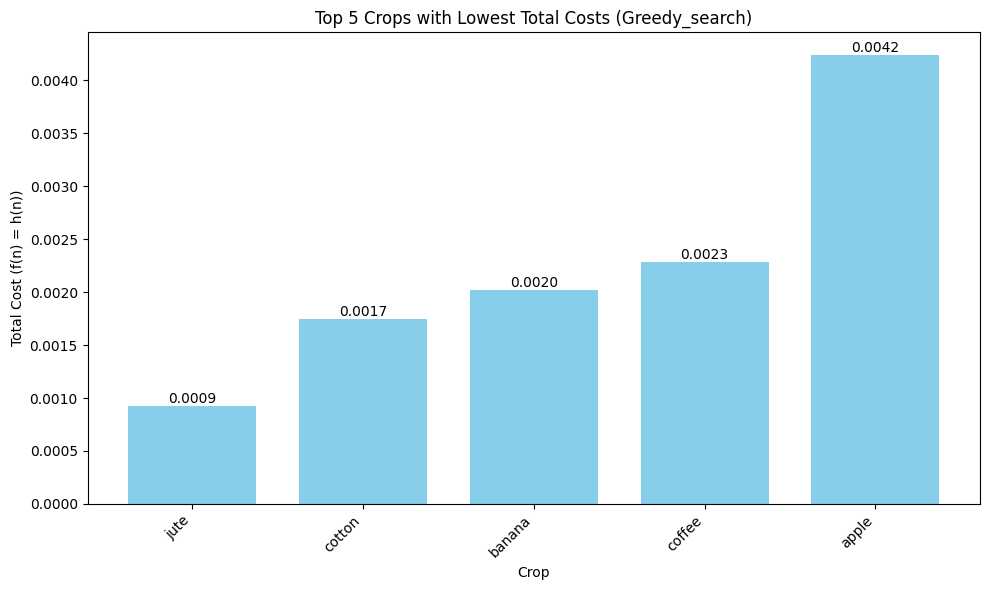


===== A* SEARCH RESULTS =====
No exact solution found. Returning top 5 crops with lowest total costs after expanding 2888 nodes.

===== NO PERFECT MATCH FOUND =====
1. jute: cost 0.0009
  Recommended Modifications:
2. cotton: cost 5.1131
  Recommended Modifications:
 apply_N_fertilizer: 50 units
3. banana: cost 9.4384
  Recommended Modifications:
 apply_K_fertilizer: 100 units
 apply_P_fertilizer: 50 units
4. coffee: cost 11.7978
  Recommended Modifications:
 apply_N_fertilizer: 100 units
 apply_P_fertilizer: 50 units
5. pigeonpeas: cost 15.9660
  Recommended Modifications:
 apply_K_fertilizer: 150 units
 apply_P_fertilizer: 100 units
 apply_N_fertilizer: 150 units
Phase expansions rendered to astar_path.pdf


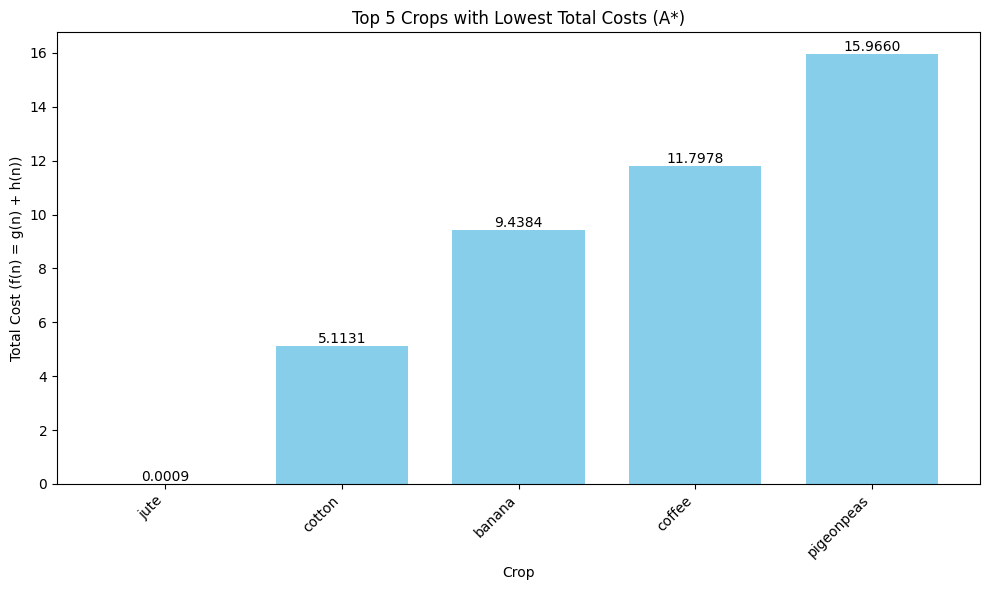


===== GENETIC ALGORITHM RESULTS =====
Generation 0: Fitness = 0.9021, Crop = jute
Generation 10: Fitness = 0.9473, Crop = jute
Generation 20: Fitness = 0.9581, Crop = jute
Generation 30: Fitness = 0.9623, Crop = jute
Generation 40: Fitness = 0.9635, Crop = jute

Best Solution: Fitness = 0.9635
Interventions: {'add_organic_matter': 0, 'irrigation_frequency': 1, 'apply_N_fertilizer': 0, 'apply_P_fertilizer': 0, 'apply_K_fertilizer': 0}

Top 5 Crops by Suitability:
jute: 95.64%
rice: 88.48%
coffee: 88.22%
papaya: 84.46%
coconut: 81.78%


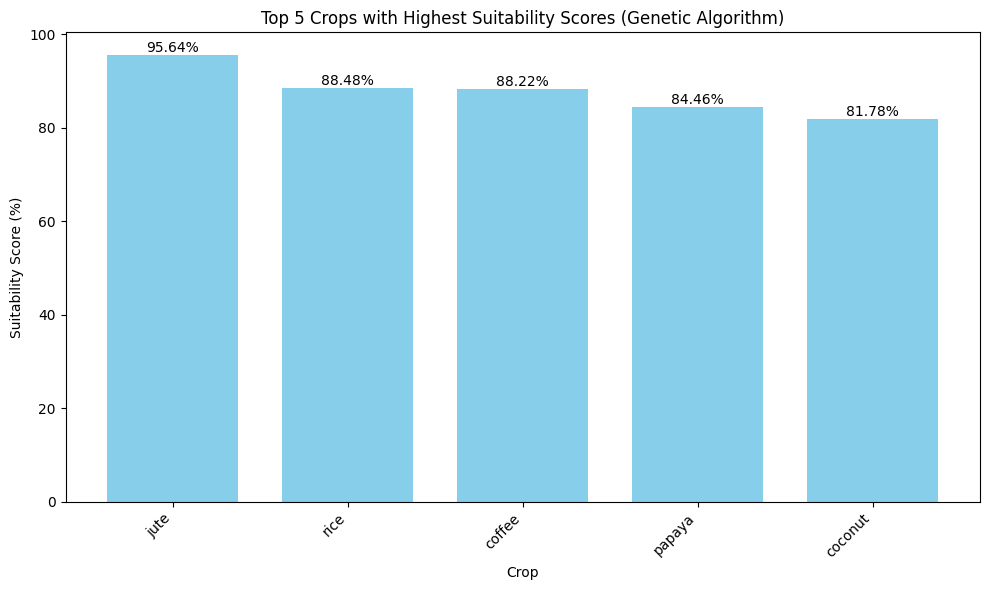


===== CSP RESULTS =====

Initial Environment:
N: 84.0
P: 51.0
K: 35.0
temperature: 22.0
humidity: 80.0
ph: 6.0
rainfall: 190.0
Selected Crop: None

Resource Adjustments:

Final Environment:
  N: 84.0
  P: 51.0
  K: 35.0
  temperature: 22.0
  humidity: 80.0
  ph: 6.0
  rainfall: 190.0

Objective Score: -inf

===== ALTERNATIVE CROP SUITABILITY =====
jute: 85.7%
  - N: 84.0 ✓ (Range: 60-100)
  - P: 51.0 ✓ (Range: 35-60)
  - K: 35.0 ✓ (Range: 35-45)
  - temperature: 22.0 ✗ (Range: 23.1-27.0)
  - humidity: 80.0 ✓ (Range: 70.9-89.9)
  - ph: 6.0 ✓ (Range: 6.0-7.5)
  - rainfall: 190.0 ✓ (Range: 150.2-199.8)
rice: 85.7%
  - N: 84.0 ✓ (Range: 60-99)
  - P: 51.0 ✓ (Range: 35-60)
  - K: 35.0 ✓ (Range: 35-45)
  - temperature: 22.0 ✓ (Range: 20.0-26.9)
  - humidity: 80.0 ✗ (Range: 80.1-85.0)
  - ph: 6.0 ✓ (Range: 5.0-7.9)
  - rainfall: 190.0 ✓ (Range: 182.6-298.6)
coffee: 57.1%
  - N: 84.0 ✓ (Range: 80-120)
  - P: 51.0 ✗ (Range: 15-40)
  - K: 35.0 ✓ (Range: 25-35)
  - temperature: 22.0 ✗ (Range: 23

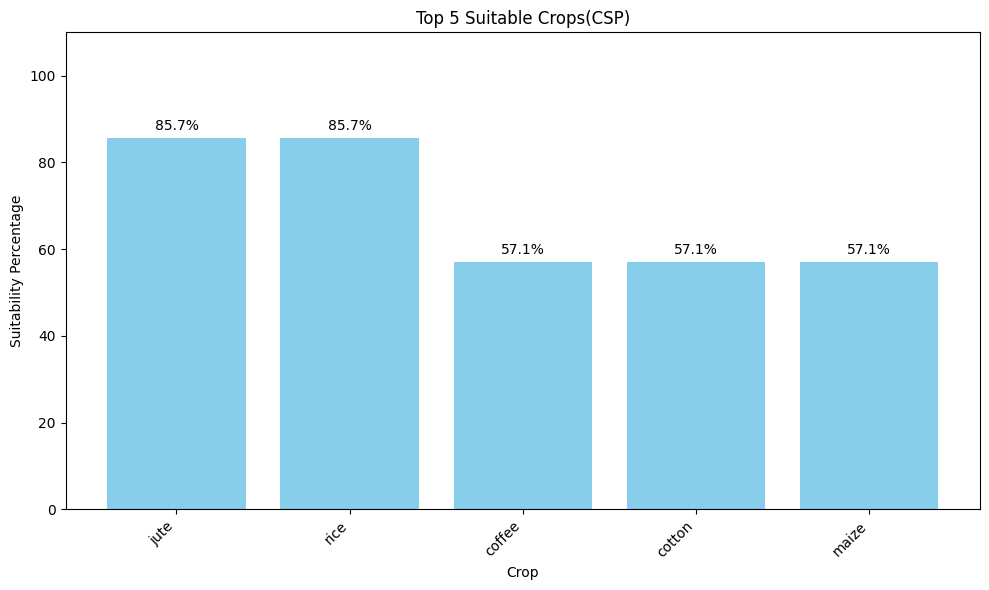


Top 5 Crops by Suitability (CSP):
jute: 85.71%
rice: 85.71%
coffee: 57.14%
cotton: 57.14%
maize: 57.14%

=== Comparison Results ===
  algorithm     time_s    mem_mb
0    Greedy   9.950027  3.451260
1        A*  20.972422  4.054696
2   Genetic  11.995390  0.967126
3       csp   0.562394  1.013537


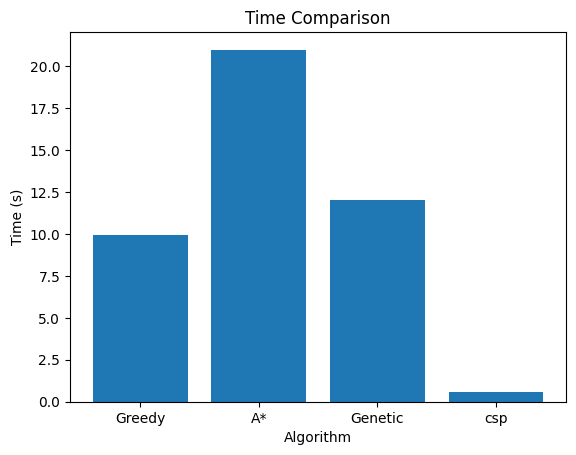

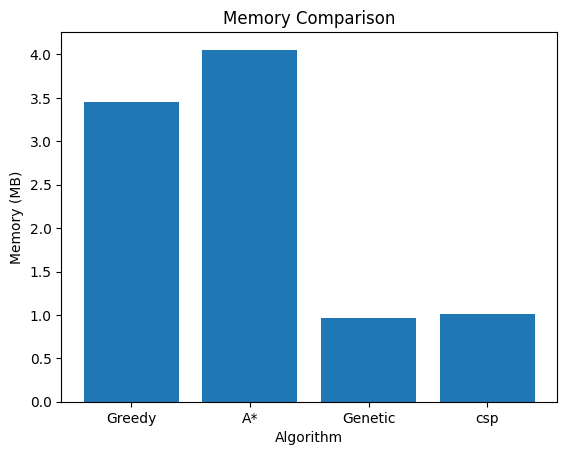

In [74]:
if __name__ == "__main__":
    # Get user input for environmental conditions
    user_input = get_user_input()
    initial_environment = np.array([
        user_input['N'],
        user_input['P'],
        user_input['K'],
        user_input['temperature'],
        user_input['humidity'],
        user_input['ph'],
        user_input['rainfall']
    ])

    initial_env = CropState(initial_environment, {})
    prob = CropPredictionProblem(initial_env, 'Crop_Data.csv')

    print("Initial Environment:")
    for f, v in zip(prob.feature_names, initial_environment):
        print(f"{f}: {v}")

    # Get user mode choice
    mode = get_user_mode_choice()

    # ------------------- Greedy -----------------------------

def run_greedy(data):
    print("\n===== GREEDY SEARCH RESULTS =====")
    goal, res, _, search, _ = run_agricultural_search(
          data,
            'Crop_Data.csv',
            "Greedy_search",
            max_depth=3,
            mode=mode
    )
    visualize_path_expansions(search.last_expanded, prob, filename='greedy_path')
    if not goal and mode == "classify":
        viz_astar = Visualize(res)
        viz_astar.create_bar_chart(top_n=5, search_strategy="Greedy_search")
    return res



    # -------------------------- A* ----------------------------

def run_astar(data):
    print("\n===== A* SEARCH RESULTS =====")
    goal, res, _, search, _ = run_agricultural_search(
        data,
        'Crop_Data.csv',
        "A*",
        max_depth=3,
        mode=mode
    )
    visualize_path_expansions(search.last_expanded, prob, filename='astar_path')
    if not goal and mode == "classify":
        viz_astar = Visualize(res)
        viz_astar.create_bar_chart(top_n=5, search_strategy="A*")
    return res


# ------------------------------ Genetic ----------------------

def run_genetic(data):
    """
    Run the Genetic Algorithm.
    """
    print("\n===== GENETIC ALGORITHM RESULTS =====")
    ga = GeneticAlgorithm(prob)

    # Run genetic algorithm
    best_solution, best_fitness, best_crop, top_crops = ga.solve(mode=mode)

    if mode == "classify":
        viz_genetic = Visualize(top_crops)
        viz_genetic.create_bar_chart(top_n=5, search_strategy="Genetic")
    elif mode == "predict":
        print("\nGenetic Algorithm Prediction Result:")
        print(f"Most Suitable Crop: {best_crop}")
        print(f"Fitness Score: {best_fitness:.4f}")
        print("Interventions:")
        interventions = dict(zip([x[0] for x in prob.interventions], best_solution))
        for action, amount in interventions.items():
            print(f"  {action}: {amount} units")

    return top_crops

def run_cspm(data):
    """
    Run the CSP algorithm.
    """
    print("\n===== CSP RESULTS =====")
    # Define resource limits (adjust as needed)
    resource_limits = {'fertilizer': 300, 'water': 300, 'organic_matter': 20}

    # Run CSP
    result = run_csp(
        initial_environment=data,
        crop_requirements=None,  # Load from file
        resource_limits=resource_limits,
        max_iterations=1000,
        visualize=True,
        mode=mode
    )

    if mode == "classify":
        print("\nTop 5 Crops by Suitability (CSP):")
        for crop, score_data in sorted(result['alternative_crops'].items(), key=lambda x: x[1]['percentage'], reverse=True)[:5]:
            print(f"{crop}: {score_data['percentage']:.2f}%")
    elif mode == "predict":
        print("\nCSP Prediction Result:")
        print(f"Most Suitable Crop: {result['crop']}")
        print("Resource Adjustments:")
        for resource, value in result['resources'].items():
            print(f"  {resource}: {value} units")
        print("Final Environment:")
        for feature, value in result['environment'].items():
            print(f"  {feature}: {value:.1f}")

    return result

    # Instantiate comparator
comp = AlgorithmComparator({
        'Greedy': run_greedy,
        'A*': run_astar,
        'Genetic':run_genetic,
        'csp':run_cspm

    })

    # Execute comparison
df = comp.compare(initial_environment)
print("\n=== Comparison Results ===")
print(df)

    # Visualize
comp.plot_time()
comp.plot_memory()


